In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import parsing_and_evaluation

# Parse model outputs
## SQuAD

In [54]:
## TO DO PARSING FUNKTIONEN ANPASSEN

from parsing_and_evaluation import (
    parse_aggregate_evaluate_squad_multi,
    parse_and_evaluate_squad_multi, 
    aggregate_confidence_squad,
    evaluate_squad_aggregated,
    normalize_squad_multi
)

df_squad = pd.read_csv("output/llm_sample_consistency/LLama3.2_1B/squad_llama_k5_topk.csv")

nonsense_answers = [
    "extracted_answer", "<answer>", "True", "Yes", "No",
    "<short answer>", "A", "B", "C", "D"
]

df_squad = df_squad[ ~df_squad["parsed_answer"].isin(nonsense_answers)]

print(f"Loaded SQuAD multi-sample data:")
print(f"- Total samples: {len(df_squad)}")
print(f"- Unique questions: {df_squad['question_id'].nunique()}")
print(f"- Samples per question: {len(df_squad) / df_squad['question_id'].nunique():.1f}")

# Check for unanswerable questions
if 'is_impossible' in df_squad.columns:
    unanswerable_count = df_squad['is_impossible'].sum()
    print(f"- Unanswerable questions: {unanswerable_count} ({unanswerable_count/len(df_squad)*100:.1f}%)")

df_parsed_squad, df_agg_squad, eval_df_squad, acc_squad = parse_aggregate_evaluate_squad_multi(
    df_squad, 
    group_col="question_id",
    similarity_threshold=0.8,  # Threshold for clustering similar answers
    remove_unanswerable=False  # Set to True if you want to exclude unanswerable questions
)

print(f"\n✅ Multi-Sample SQuAD Results (Modularized):")
print(f"   - Valid parsed samples: {df_parsed_squad['parsed_answer'].notna().sum()}")
print(f"   - Number of unique questions: {df_parsed_squad['question_id'].nunique()}")


Loaded SQuAD multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0
- Unanswerable questions: 950 (38.0%)

✅ Multi-Sample SQuAD Results (Modularized):
   - Valid parsed samples: 2497
   - Number of unique questions: 500


## TriviaQA

In [ ]:
## TO DO PARSING FUNKTIONEN ANPASSEN

from parsing_and_evaluation import (
    parse_aggregate_evaluate_trivia_multi,
    parse_and_evaluate_trivia_multi, 
    aggregate_confidence_trivia,
    evaluate_trivia_aggregated,
    normalize_trivia_multi
)

# Load dataset
df_trivia = pd.read_csv("output/llm_sample_consistency/LLama3.2_1B/trivia_llama_k5_topk.csv")

# Remove any rows with non-sense answers in parsed_answer column
nonsense_answers = [
    "A", "B", "C", "D", "E", "F",
    "True", "<string>", "extracted_answer"
]

df_trivia = df_trivia[~df_trivia["parsed_answer"].isin(nonsense_answers)]

print(f"Loaded TriviaQA multi-sample data:")
print(f"- Total samples: {len(df_trivia)}")
print(f"- Unique questions: {df_trivia['question_id'].nunique()}")
print(f"- Samples per question: {len(df_trivia) / df_trivia['question_id'].nunique():.1f}")

# Parsing and normalizing the model outputs
df_parsed_trivia, df_agg_trivia, eval_df_trivia, acc_trivia = parse_aggregate_evaluate_trivia_multi(
    df_trivia, 
    group_col="question_id",
    similarity_threshold=0.8  # Threshold for clustering similar answers
)

print(f"\n✅ Multi-Sample TriviaQA Results (Modularized):")
valid_parsed_trivia = df_parsed_trivia.dropna(subset=["parsed_answer"])
print(f"   - Valid parsed samples: {len(valid_parsed_trivia)}")
print(f"   - Number of unique questions: {df_parsed_trivia['question_id'].nunique()}")

Loaded TriviaQA multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0

✅ Multi-Sample TriviaQA Results (Modularized):
   - Valid parsed samples: 2463
   - Number of unique questions: 500


# Helper functions for similarity measures

## SentenceBERT
- **mean_similarity**: mean value of all pairwise cosine similarities between the answer-embeddings
    - Values near 1 imply that the answers are very similar (high consistency)
- **std_similarity**: deviation of similarities -> how different the pairs are
    - high values imply that some pairs are very similar and other very unsimilar
    - analyse how equally consistent the pairs are
- **n_pairs**: how many pair comparisons were made for the calculation of similarity -> $n\_pairs = \binom{n}{2}$

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_sentenceBERT_similarity(df, question_id_col, answer_col, is_impossible_col=None):
    """
    Calculates similarity statistics for questions with multiple answers.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        question_id_col (str): The name of the column containing question IDs.
        answer_col (str): The name of the column containing answers.
        is_impossible_col (str, optional): The name of the column indicating if the question is impossible.
                                           If None, this column is ignored.

    Returns:
        pd.DataFrame: A DataFrame with the calculated similarity statistics.
    """
    similarity_stats = []

    # If is_impossible_col is provided, process separately for True and False
    if is_impossible_col:
        for is_impossible_value in [False, True]:
            df_filtered = df[df[is_impossible_col] == is_impossible_value]
            grouped = df_filtered.groupby(question_id_col)

            for qid, group in grouped:
                answers = group[answer_col].dropna().tolist()

                # Only compute similarity if there are at least 2 answers
                if len(answers) >= 2:
                    embeddings = model.encode(answers, convert_to_tensor=True)
                    sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
                    i_upper = np.triu_indices(len(answers), k=1)
                    sim_scores = sim_matrix[i_upper]

                    similarity_stats.append({
                        "question_id": qid,
                        "is_impossible": is_impossible_value,
                        "num_answers": len(answers),
                        "mean_similarity": sim_scores.mean(),
                        "std_similarity": sim_scores.std(),
                        "n_pairs": len(sim_scores)
                    })

    else:
        # If is_impossible_col is not provided, process all questions together
        grouped = df.groupby(question_id_col)

        for qid, group in grouped:
            answers = group[answer_col].dropna().tolist()

            # Only compute similarity if there are at least 2 answers
            if len(answers) >= 2:
                embeddings = model.encode(answers, convert_to_tensor=True)
                sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
                i_upper = np.triu_indices(len(answers), k=1)
                sim_scores = sim_matrix[i_upper]

                similarity_stats.append({
                    "question_id": qid,
                    "num_answers": len(answers),
                    "mean_similarity": sim_scores.mean(),
                    "std_similarity": sim_scores.std(),
                    "n_pairs": len(sim_scores)
                })

    return pd.DataFrame(similarity_stats)

# Analysis of SQuAD Dataset
## Consistency between model answers

In [ ]:
# Compute SentenceBERT similarity for SQuAD dataset
similarity_df_squad = compute_sentenceBERT_similarity(
    df=df_parsed_squad,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col="is_impossible"
)
similarity_df_squad["dataset"] = "SQuAD"

print(similarity_df_squad.shape)

num_unanswerable = similarity_df_squad[similarity_df_squad["is_impossible"] == True].shape[0]
print(f"Number of unanswerable questions in similarity_df_squad: {num_unanswerable}")

similarity_df_squad.head(15)

(500, 7)
Number of unanswerable questions in similarity_df_squad: 190


,question_id,is_impossible,num_answers,mean_similarity,std_similarity,n_pairs,dataset
0,0,False,5,1.000000,5.960464e-08,10,SQuAD
1,1,False,5,0.691313,1.123524e-01,10,SQuAD
2,2,False,5,0.389219,1.484323e-01,10,SQuAD
3,3,False,5,0.406576,4.236245e-01,10,SQuAD
4,4,False,5,0.384164,4.165010e-01,10,SQuAD
5,5,False,5,0.474839,3.582628e-01,10,SQuAD
6,6,False,5,0.377643,4.878722e-01,10,SQuAD
7,7,False,5,0.577356,5.176307e-01,10,SQuAD
8,8,False,5,0.396200,3.965014e-01,10,SQuAD
9,9,False,5,0.667697,4.069867e-01,10,SQuAD



Unanswerable Questions Count:
is_impossible
False    310
True     190
Name: count, dtype: int64


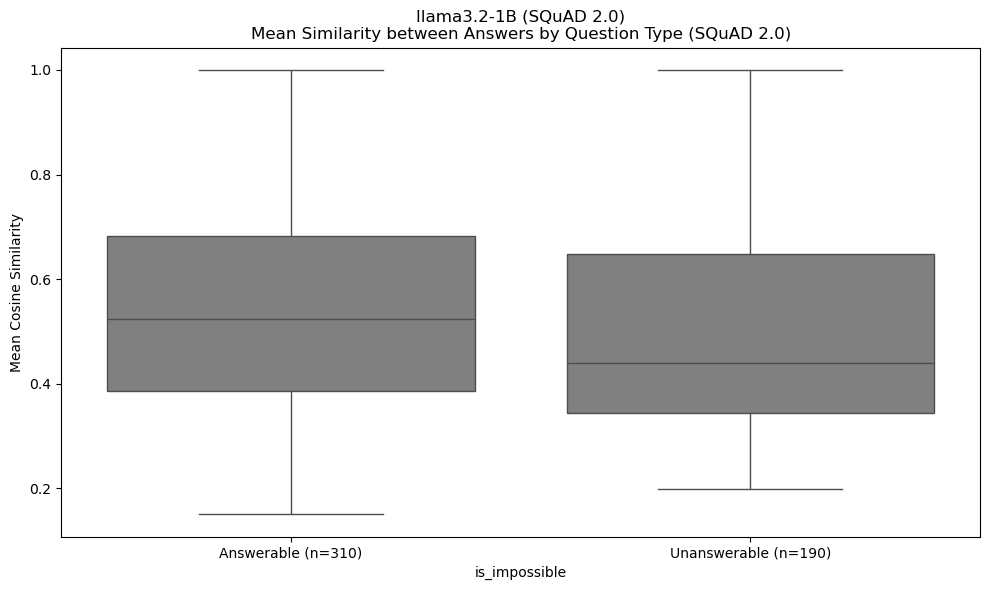

In [73]:
count_impossible = similarity_df_squad['is_impossible'].value_counts()
print(f"\nUnanswerable Questions Count:\n{count_impossible}")

# Compare mean similarity (consistency) between unanswerable and answerable questions
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="is_impossible",
    y="mean_similarity",
    data=similarity_df_squad,
    showfliers=True,
    color="grey"
)
plt.title("llama3.2-1B (SQuAD 2.0)\nMean Similarity between Answers by Question Type (SQuAD 2.0)")
plt.ylabel("Mean Cosine Similarity")
plt.xticks([0, 1], ["Answerable (n=310)", "Unanswerable (n=190)"])
plt.tight_layout()
plt.show()

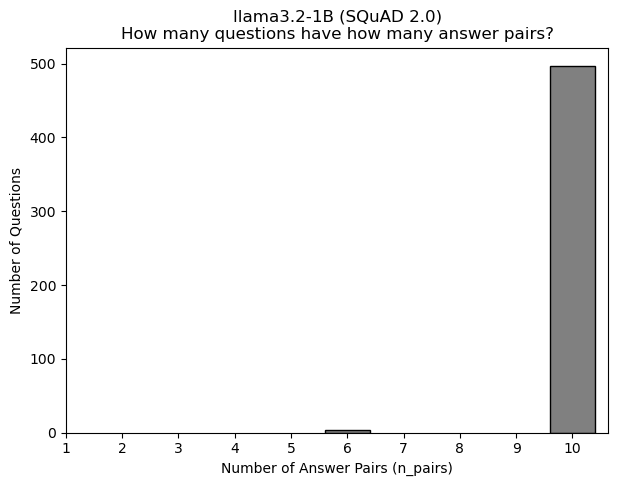

In [ ]:
# Count the number of answer pairs (n_pairs) for SQuAD dataset
pair_counts = similarity_df_squad["n_pairs"].value_counts().sort_index()
plt.figure(figsize=(7, 5))
plt.bar(pair_counts.index, pair_counts.values, width=0.8, edgecolor='black', color='grey')
plt.xlabel("Number of Answer Pairs (n_pairs)")
plt.ylabel("Number of Questions")
plt.title("llama3.2-1B (SQuAD 2.0)\nHow many questions have how many answer pairs?")
plt.xticks(range(1, 11))
#plt.savefig("figures/metrics/sampling_consistency/distribution_npairs_trivia_llama3.2.png")
plt.show()

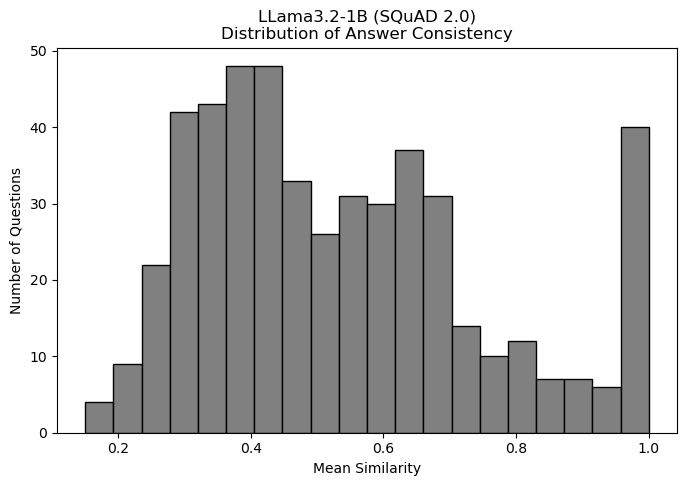

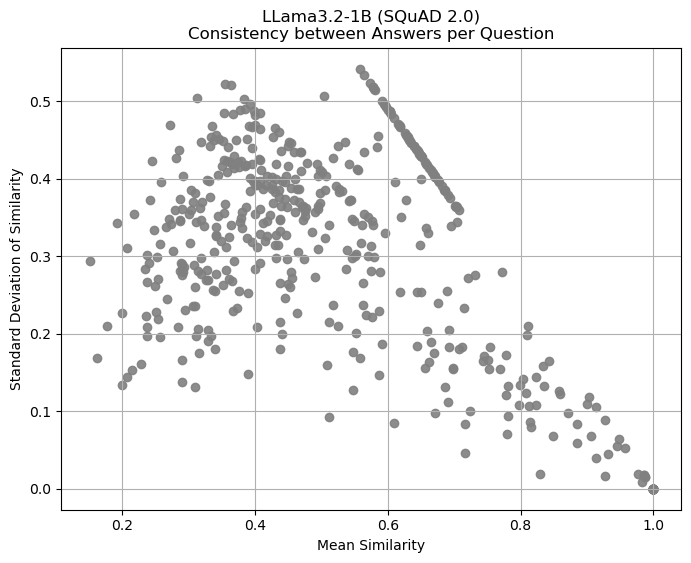

In [ ]:
# Plot distribution of mean similarity
plt.figure(figsize=(8, 5))
plt.hist(similarity_df_squad["mean_similarity"], bins=20, color="grey", edgecolor='black')
plt.xlabel("Mean Similarity")
plt.ylabel("Number of Questions")
plt.title("LLama3.2-1B (SQuAD 2.0)\nDistribution of Answer Consistency")
#plt.savefig("figures/metrics/sampling_consistency/consistency_distribution_squad_llama3.2.png")
plt.show()

# Plot consistency of answers per question
plt.figure(figsize=(8, 6))
plt.scatter(similarity_df_squad["mean_similarity"], similarity_df_squad["std_similarity"], alpha=0.9, color='grey')
plt.xlabel("Mean Similarity")
plt.ylabel("Standard Deviation of Similarity")
plt.title("LLama3.2-1B (SQuAD 2.0)\nConsistency between Answers per Question")
#plt.savefig("figures/metrics/sampling_consistency/consistency_std_mean_squad_llama3.2.png")
plt.grid(True)
plt.show()

FINDINGS
- peak at moderate mean similarity: questions still allow for varying interpretations
- distribution of mean similarity is farily broad
- strong negative correlation between std and mean similarity -> Higher mean similarity (higher consistency) implies lower variability among responses
- questions with very high mean similarity have almost no variability -> asnwers to these questions are nearly identical

## Generate Correctness of answers
Correctness is generated by computing the SentenceBERT similarity between the model answers and the ground truth answers.

- **mean_similarity:** how close are the model's answers on average to ground truth\
-> high mean similarity: model tends to produce answers that are semantically close to ground truth
- **std:** How stable or uncertain the model is with respect to the correct answer\
-> low std: model is consistent (all answers are similarily correct)

In [ ]:
# Load original SQuAD dataset to merge with parsed results
df_squad_original = pd.read_csv("data/SQuAD2_merged.csv")
df_squad_merged = df_parsed_squad.merge(df_squad_original[['id', 'answers']], on='id', how='left', suffixes=('', '_gt'))
df_squad_merged

,id,title,question,context,answers,is_impossible,prompt,question_id,sample_id,model_output,parsed_answer,parsed_confidence,answers_gt
0,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,0,NaN,nan,NaN,['promotion of right-wing ministers to the cab...
1,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,1,NaN,nan,NaN,['promotion of right-wing ministers to the cab...
2,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,2,NaN,nan,NaN,['promotion of right-wing ministers to the cab...
3,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,3,NaN,nan,NaN,['promotion of right-wing ministers to the cab...
4,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,4,NaN,nan,NaN,['promotion of right-wing ministers to the cab...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,572ff73b04bcaa1900d76f4b,Roman_Republic,How many Romans lived in Mithridate the Great'...,"Mithridates the Great was the ruler of Pontus,...","['80,000']",False,You are a QA assistant. Use the context to ans...,499,0,"Answer: 80,000.",80000,NaN,"['80,000']"
2496,572ff73b04bcaa1900d76f4b,Roman_Republic,How many Romans lived in Mithridate the Great'...,"Mithridates the Great was the ruler of Pontus,...","['80,000']",False,You are a QA assistant. Use the context to ans...,499,1,"""}{""answer"": ""80,000""}{""text"": ""Mithridates th...",80000,NaN,"['80,000']"
2497,572ff73b04bcaa1900d76f4b,Roman_Republic,How many Romans lived in Mithridate the Great'...,"Mithridates the Great was the ruler of Pontus,...","['80,000']",False,You are a QA assistant. Use the context to ans...,499,2,"A) 20,000\nB) 80,000\nC) 100,000\nD) 200,000\n...",b 80000,NaN,"['80,000']"
2498,572ff73b04bcaa1900d76f4b,Roman_Republic,How many Romans lived in Mithridate the Great'...,"Mithridates the Great was the ruler of Pontus,...","['80,000']",False,You are a QA assistant. Use the context to ans...,499,3,"Answer: 80,000.",80000,NaN,"['80,000']"


In [ ]:
# Extract Ground Truth answers from the original SQuAD dataset
def extract_gt(answer_str):
    try:
        return eval(answer_str)[0]
    except:
        return None

df_squad_merged['gt_answer'] = df_squad_merged['answers'].apply(extract_gt)

# Drop rows where parsed_answer or gt_answer is NaN
df_squad_merged = df_squad_merged.dropna(subset=['parsed_answer', 'gt_answer'])

# Load SentenceBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute similarity between parsed answers and ground truth answers
def compute_similarity(row):
    emb1 = model.encode(row['parsed_answer'], convert_to_tensor=True)
    emb2 = model.encode(row['gt_answer'], convert_to_tensor=True)
    return float(util.cos_sim(emb1, emb2).item())

df_squad_merged['sbert_to_gt'] = df_squad_merged.apply(compute_similarity, axis=1)

# Aggregate similarity statistics
agg_df_squad = df_squad_merged.groupby(['question_id', 'is_impossible'])['sbert_to_gt'].agg(['mean', 'std']).reset_index()
agg_df_squad.head(15)

/var/folders/mf/zdrsq7ms1cs8nyqwtp9c01th0000gp/T/ipykernel_64205/872133880.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_squad_merged['gt_answer'] = df_squad_merged['answers'].apply(extract_gt)


,question_id,is_impossible,mean,std,min,max
0,0,False,0.013209,0.000000,0.013209,0.013209
1,1,False,0.781192,0.174767,0.624618,0.970495
2,2,False,0.563140,0.295703,0.207622,1.000000
3,3,False,0.411051,0.388191,0.145073,1.000000
4,4,False,0.131417,0.267616,-0.044150,0.561044
5,5,False,0.428181,0.353036,0.198712,1.000000
6,6,False,0.472735,0.358256,0.080334,0.742406
7,7,False,0.081607,0.344018,-0.072242,0.697004
8,8,False,0.325545,0.352941,0.132142,0.945599
9,9,False,0.109804,0.101726,0.064311,0.291776


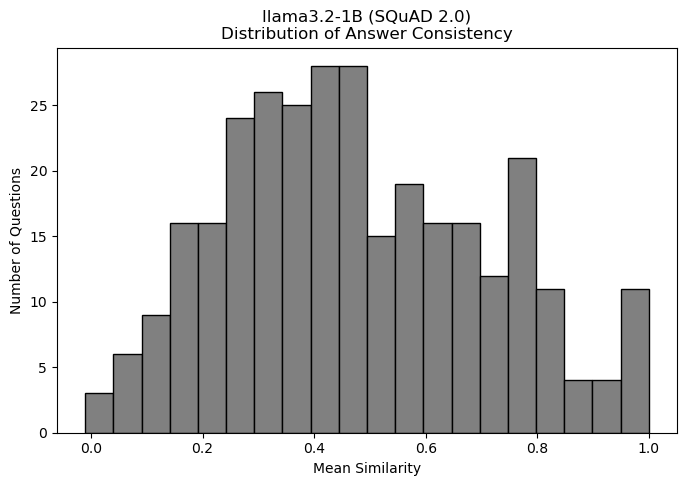

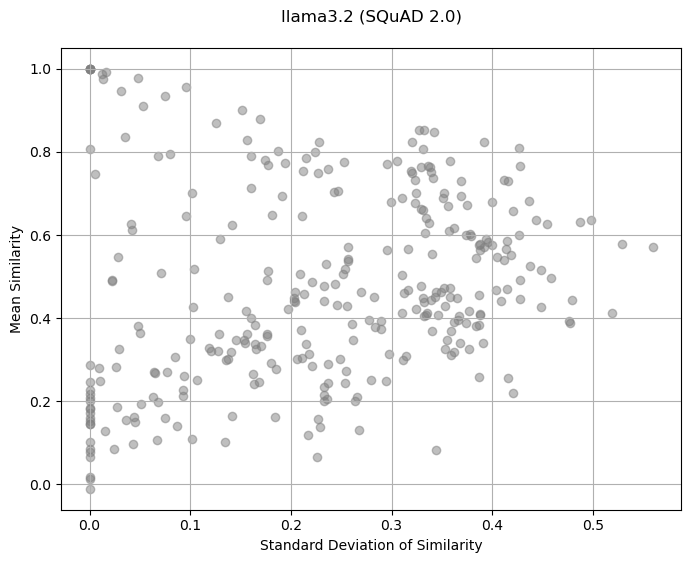

In [ ]:
# Plot distribution of mean similarity
plt.figure(figsize=(8, 5))
plt.hist(agg_df_squad['mean'], bins=20, color='grey', edgecolor='black')
plt.xlabel("Mean Similarity")
plt.ylabel("Number of Questions")
plt.title("llama3.2-1B (SQuAD 2.0)\nDistribution of Answer Correctness")
#plt.savefig("figures/metrics/sampling_consistency/consistency_distribution_squad_llama3.2.png")
plt.show()

# 
plt.figure(figsize=(8,6))
plt.scatter(agg_df_squad['std'], agg_df_squad['mean'], alpha=0.5, color='grey')
plt.xlabel("Standard Deviation of Similarity")
plt.ylabel("Mean Similarity")
plt.title("llama3.2 (SQuAD 2.0)\n")
plt.grid(True)
plt.show()

- The higher uncertainty (higher values of sdt), the lower the similarity to ground truth -> negative correlation between uncertainty and quality
- If model is not so certain (more variation), it is more likely wrong
- Std~0 implies no variation at all, but the quality (mean similarity) is not necessarily high\
    -> high consistency doesn't necessarily mean that the answer is correct
- Std>0.3 implies high uncertainty but low similarites at the same time (might be unanswerable questions -> CHECK)

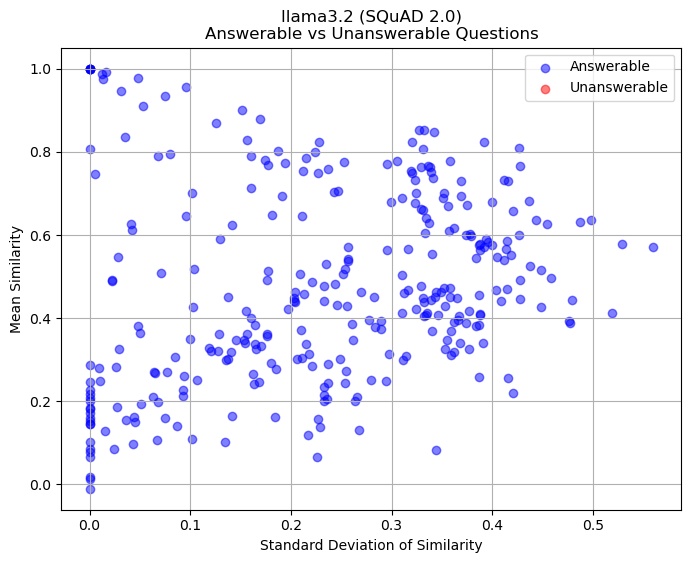

In [82]:
# Scatterplot of std vs mean similarity for unanswerable and answerable questions
df_ans = agg_df_squad[agg_df_squad['is_impossible'] == False]
df_unans = agg_df_squad[agg_df_squad['is_impossible'] == True]

plt.figure(figsize=(8,6))
plt.scatter(df_ans['std'], df_ans['mean'], alpha=0.5, label='Answerable', color='blue')
plt.scatter(df_unans['std'], df_unans['mean'], alpha=0.5, label='Unanswerable', color='red')
plt.xlabel("Standard Deviation of Similarity")
plt.ylabel("Mean Similarity")
plt.title("llama3.2 (SQuAD 2.0)\nAnswerable vs Unanswerable Questions")
plt.legend()
plt.grid(True)
plt.show()


# Analysis of TriviaQA Dataset
## Consistency between model answers

In [85]:
# Compute SentenceBERT similarity for TriviaQA dataset
similarity_df_trivia = compute_sentenceBERT_similarity(
    df=df_parsed_trivia,
    question_id_col="question_id",
    answer_col="parsed_answer"
)
similarity_df_trivia["dataset"] = "TriviaQA"

print(similarity_df_trivia.shape)
print(similarity_df_trivia.head(15))

(499, 6)
    question_id  num_answers  mean_similarity  std_similarity  n_pairs  \
0             0            4         0.288603        0.163215        6   
1             1            5         0.281912        0.258958       10   
2             2            5         0.274300        0.180328       10   
3             3            5         0.322262        0.254639       10   
4             4            4         0.440509        0.252386        6   
5             5            5         0.273759        0.238799       10   
6             6            5         0.273370        0.126282       10   
7             7            4         0.644452        0.355548        6   
8             8            5         0.336051        0.177401       10   
9             9            5         0.210508        0.175956       10   
10           10            5         0.261877        0.216773       10   
11           11            4         0.357766        0.231450        6   
12           12            5 

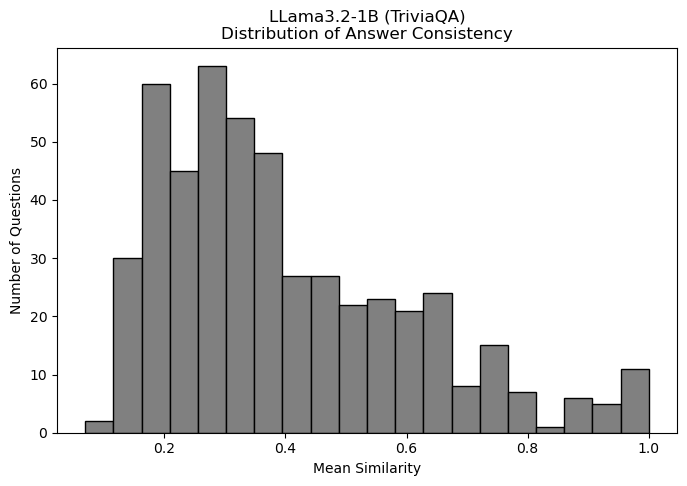

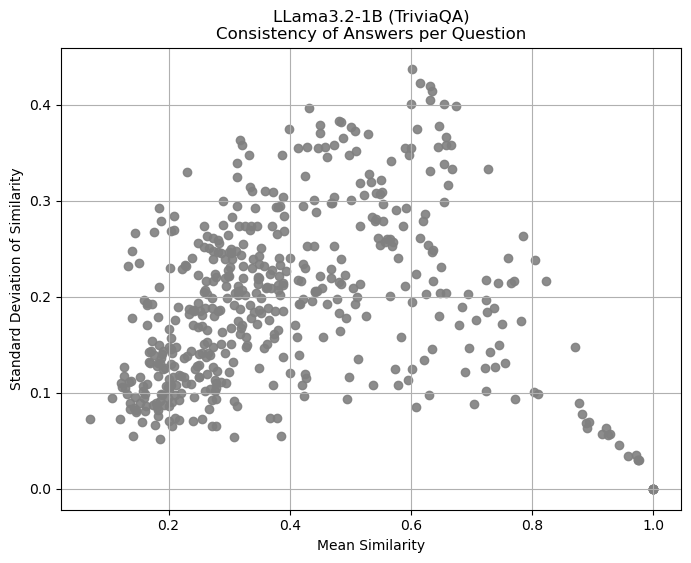

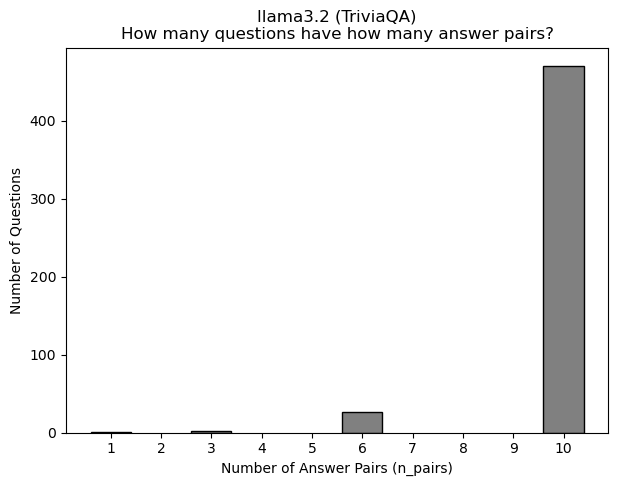

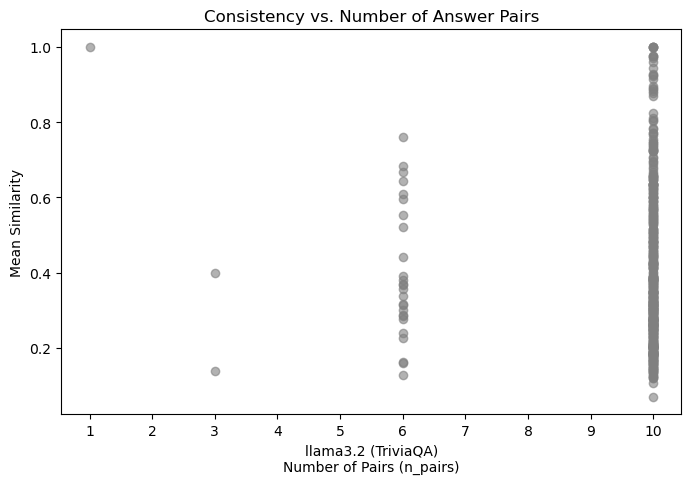

In [89]:
# Distribution of mean similarity for TriviaQA dataset
plt.figure(figsize=(8, 5))
plt.hist(similarity_df_trivia["mean_similarity"], bins=20, color="grey", edgecolor='black')
plt.xlabel("Mean Similarity")
plt.ylabel("Number of Questions")
plt.title("LLama3.2-1B (TriviaQA)\nDistribution of Answer Consistency")
#plt.savefig("figures/metrics/sampling_consistency/consistency_distribution_trivia_llama3.2.png")
plt.show()

# Consistency of answers per question for TriviaQA dataset
plt.figure(figsize=(8, 6))
plt.scatter(similarity_df_trivia["mean_similarity"], similarity_df_trivia["std_similarity"], alpha=0.9, color='grey')
plt.xlabel("Mean Similarity")
plt.ylabel("Standard Deviation of Similarity")
plt.title("LLama3.2-1B (TriviaQA)\nConsistency of Answers per Question")
plt.grid(True)
#plt.savefig("figures/metrics/sampling_consistency/consistency_std_mean_trivia_llama3.2.png")
plt.show()

# Count the number of answer pairs (n_pairs) for TriviaQA dataset
pair_counts = similarity_df_trivia["n_pairs"].value_counts().sort_index()
plt.figure(figsize=(7, 5))
plt.bar(pair_counts.index, pair_counts.values, width=0.8, edgecolor='black', color='grey')
plt.xlabel("Number of Answer Pairs (n_pairs)")
plt.ylabel("Number of Questions")
plt.title("llama3.2 (TriviaQA)\nHow many questions have how many answer pairs?")
plt.xticks(range(1, 11))
#plt.savefig("figures/metrics/sampling_consistency/distribution_npairs_trivia_llama3.2.png")
plt.show()

# Scatterplot of n_pairs vs mean similarity for TriviaQA dataset
plt.figure(figsize=(8, 5))
plt.scatter(similarity_df_trivia["n_pairs"], similarity_df_trivia["mean_similarity"], alpha=0.6, color='grey')
plt.xlabel("llama3.2 (TriviaQA)\nNumber of Pairs (n_pairs)")
plt.ylabel("Mean Similarity")
plt.title("Consistency vs. Number of Answer Pairs")
plt.xticks(range(1, 11))
#plt.savefig("figures/metrics/sampling_consistency/npairs_consistencymean_trivia_llama3.2.png")
plt.show()

<Figure size 700x500 with 0 Axes>

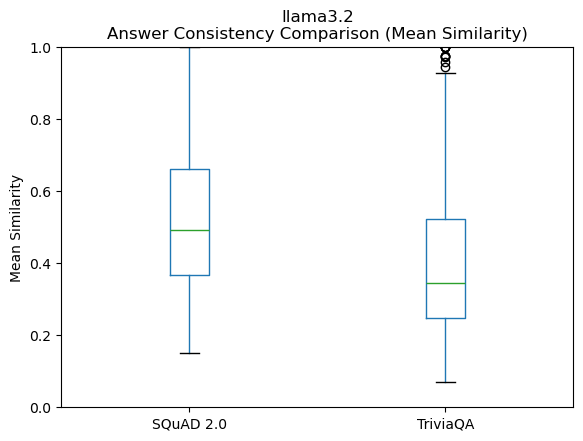

In [90]:
# Compare SQuAD and TriviaQA
similarity_df_squad["dataset"] = "SQuAD 2.0"
similarity_df_trivia["dataset"] = "TriviaQA"
combined = pd.concat([similarity_df_squad, similarity_df_trivia], ignore_index=True)

plt.figure(figsize=(7, 5))
combined.boxplot(by="dataset", column="mean_similarity", grid=False)
plt.title("llama3.2\nAnswer Consistency Comparison (Mean Similarity)")
plt.suptitle("")
plt.ylabel("Mean Similarity")
plt.xlabel("")
plt.ylim(0, 1)
plt.savefig("figures/metrics/sampling_consistency/consistency_comparison_squad_trivia_llama3.2.png")
plt.show()

## Generate Correctness of model answers

In [91]:
df_trivia_original = pd.read_csv("data/triviaqa-unfiltered/trivia_all.csv")
df_trivia_merged = df_parsed_trivia.merge(df_trivia_original[['question', 'answers']], on='question', how='left', suffixes=('', '_gt'))
df_trivia_merged.head(15)

,question,question_id,question_source,answers,prompt,sample_id,model_output,parsed_answer,parsed_confidence,answers_gt
0,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,0,(5 points)\n\nWhat is the result of dividing a...,is c the quotient,NaN,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re..."
1,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,1,"(A) Fraction, (B) Integer, (C) Decimal, (D) De...",is d},NaN,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re..."
2,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,2,(1) One\n(2) Zero\n(3) One-half\n(4) Square ro...,is $\boxed{4}$,NaN,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re..."
3,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,3,&quot;\n\nA) Quotient\nB) Remainder\nC) Produc...,is $\boxed{a}$,NaN,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re..."
4,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,4,NaN,None,NaN,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re..."
5,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,0,A) The Lamb & Flag\nB) The Eagle and Child\nC)...,a the lamb & flag,NaN,"['The Blind Beggar', 'blind beggar', 'Blind Be..."
6,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,1,A) The Eagle and Child\nB) The Spaniards Inn\n...,b the spaniards inn,NaN,"['The Blind Beggar', 'blind beggar', 'Blind Be..."
7,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,2,A) The Eagle\nB) The Lamb & Flag\nC) The Crane...,a the eagle,NaN,"['The Blind Beggar', 'blind beggar', 'Blind Be..."
8,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,3,"In 1962, Ronnie Kray was sentenced to 30 years...",a the lamb & flag,NaN,"['The Blind Beggar', 'blind beggar', 'Blind Be..."
9,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,4,A) The Sherlock Holmes pub \nB) The Sherlock H...,is e,NaN,"['The Blind Beggar', 'blind beggar', 'Blind Be..."


In [92]:
# Extract Ground Truth
def extract_gt(answer_str):
    try:
        return eval(answer_str)[0]
    except:
        return None

df_trivia_merged['gt_answer'] = df_trivia_merged['answers'].apply(extract_gt)
df_trivia_merged = df_trivia_merged.dropna(subset=['parsed_answer', 'gt_answer'])

# Compute SBERT similarity to ground truth
def compute_similarity(row):
    emb1 = model.encode(row['parsed_answer'], convert_to_tensor=True)
    emb2 = model.encode(row['gt_answer'], convert_to_tensor=True)
    return float(util.cos_sim(emb1, emb2).item())

df_trivia_merged['sbert_to_gt'] = df_trivia_merged.apply(compute_similarity, axis=1)

# Aggregation pro Frage
agg_df_trivia = df_trivia_merged.groupby('question_id')['sbert_to_gt'].agg(['mean', 'std', 'min', 'max']).reset_index()

In [93]:
agg_df_trivia.head(15)

,question_id,mean,std,min,max
0,0,0.173989,0.113735,0.058468,0.325838
1,1,0.186323,0.066193,0.074141,0.250226
2,2,0.190998,0.094613,0.106202,0.298147
3,3,0.388431,0.181409,0.144536,0.634027
4,4,0.224235,0.086239,0.147279,0.298903
5,5,0.397257,0.348015,0.118677,1.000000
6,6,0.382174,0.232342,0.174801,0.646148
7,7,0.541725,0.217038,0.216168,0.650244
8,8,0.170895,0.065432,0.077648,0.245814
9,9,0.281013,0.154804,0.095518,0.475234


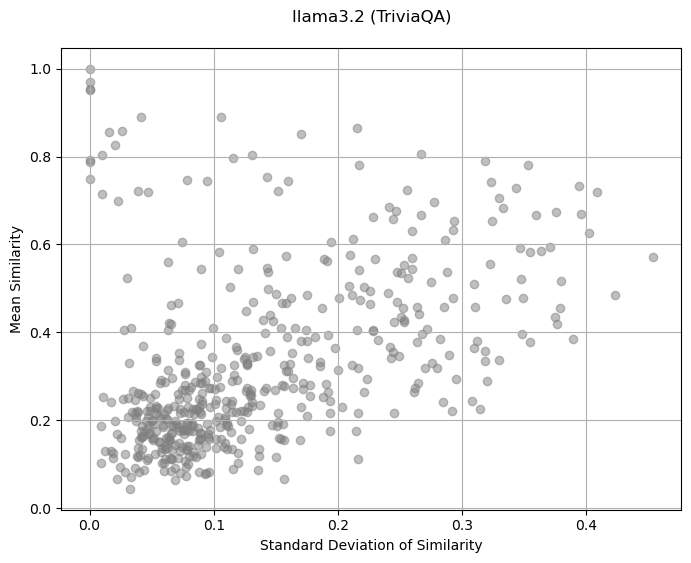

In [94]:
plt.figure(figsize=(8,6))
plt.scatter(agg_df_trivia['std'], agg_df_trivia['mean'], alpha=0.5, color='grey')
plt.xlabel("Standard Deviation of Similarity")
plt.ylabel("Mean Similarity")
plt.title("llama3.2 (TriviaQA)\n")
plt.grid(True)
plt.show()

- Model gives repeated wrong answers, which differ not much -> is consistently wrong
- not strong relationship between uncertainty and consistency -> uncertainty is not a good measurement for quality

# Comparison between datasets

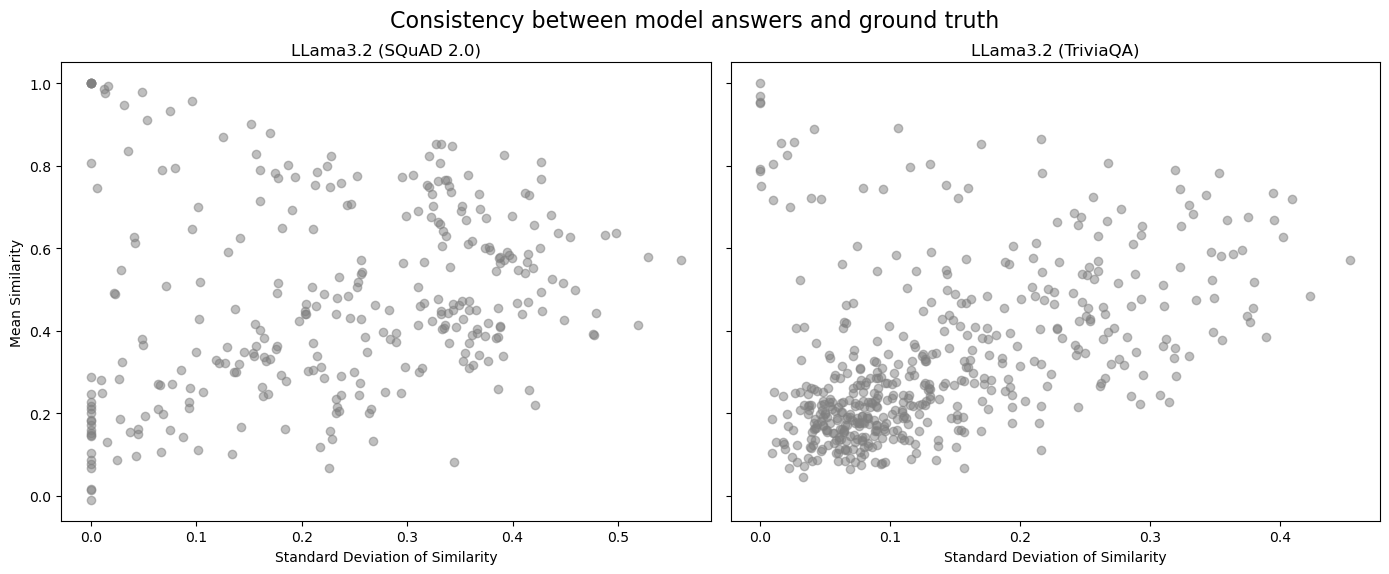

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].scatter(agg_df_squad['std'], agg_df_squad['mean'], alpha=0.5, color='gray')
axes[0].set_title("LLama3.2-1B (SQuAD 2.0)")
axes[0].set_xlabel("Standard Deviation of Similarity")
axes[0].set_ylabel("Mean Similarity")

axes[1].scatter(agg_df_trivia['std'], agg_df_trivia['mean'], alpha=0.5, color='gray')
axes[1].set_title("LLama3.2-1B (TriviaQA)")
axes[1].set_xlabel("Standard Deviation of Similarity")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Consistency between model answers and ground truth", fontsize=16)
plt.show()

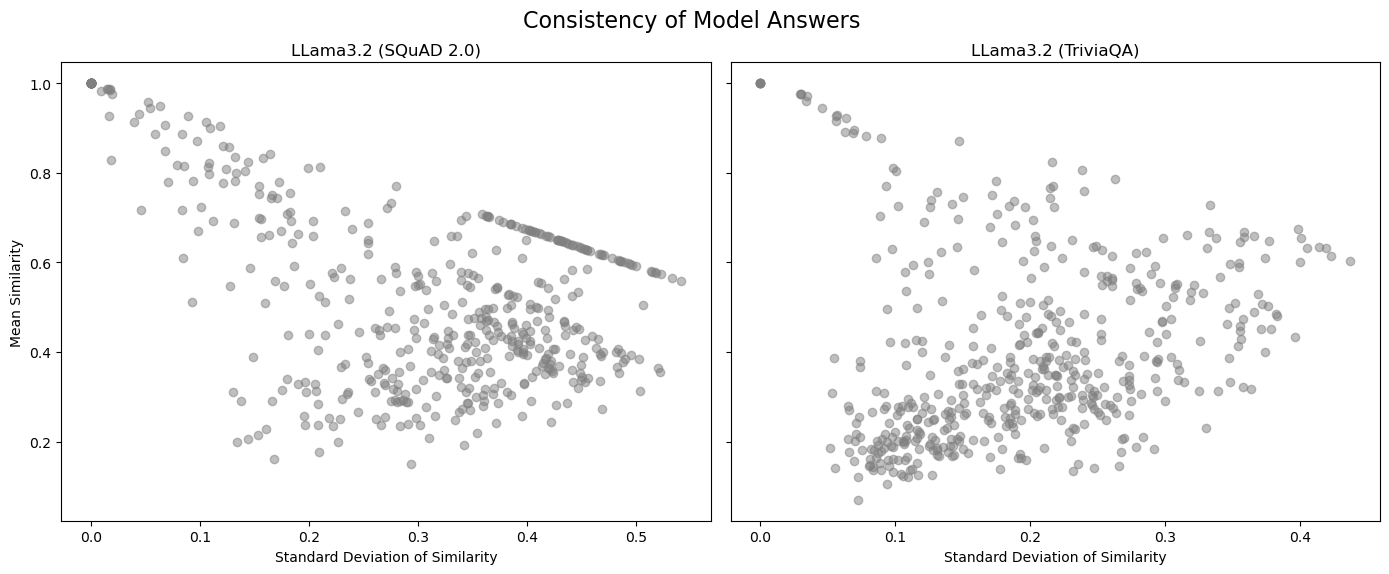

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].scatter(similarity_df_squad['std_similarity'], similarity_df_squad['mean_similarity'], alpha=0.5, color='grey')
axes[0].set_title("LLama3.2-1B (SQuAD 2.0)")
axes[0].set_xlabel("Standard Deviation of Similarity")
axes[0].set_ylabel("Mean Similarity")

axes[1].scatter(similarity_df_trivia['std_similarity'], similarity_df_trivia['mean_similarity'], alpha=0.5, color='grey')
axes[1].set_title("LLama3.2-1B (TriviaQA)")
axes[1].set_xlabel("Standard Deviation of Similarity")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Consistency of Model Answers ", fontsize=16)
plt.show()

# Compute evaluation metrics (ECE, AUROC)
- Measure confidence via average similarity between model answers and ground truth\
OR via low variation -> confidence = 1-std
- accuracy = average similarity between model answers and ground truth needs to be bigger than 0.8

## Helper functions to compute evaluation metrics

In [98]:
def compute_ece(confidences, accuracies, n_bins=10):
    bin_bounds = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        # Bin bounds
        bin_lower = bin_bounds[i]
        bin_upper = bin_bounds[i + 1]

        # Filter confidences and accuracies within the bin
        mask = (confidences > bin_lower) & (confidences <= bin_upper)
        bin_confs = confidences[mask]
        bin_accs = accuracies[mask]

        if len(bin_confs) > 0:
            avg_conf = bin_confs.mean()
            avg_acc = bin_accs.mean()
            ece += (len(bin_confs) / len(confidences)) * abs(avg_conf - avg_acc)

    return ece

In [114]:
from sklearn.metrics import roc_auc_score

## SQuAD

In [127]:
# Compute Accuracy for SQuAD dataset
agg_df_squad["is_correct"] = (agg_df_squad["mean"] > 0.8).astype(int)
accuracy_squad = agg_df_squad["is_correct"].mean()
print(f"Accuracy for SQuAD dataset: {accuracy_squad:.4f}")

# Compute ECE for SQuAD dataset
ece_squad = compute_ece(
    agg_df_squad["mean"],
    (agg_df_squad["mean"] > 0.8).astype(int)
)
print(f"ECE for SQuAD dataset: {ece_squad:.4f}")

# Compute AUROC for SQuAD dataset
auroc_squad = roc_auc_score(
    (agg_df_squad["mean"] > 0.8).astype(int),
    agg_df_squad["mean"]
)
print(f"AUROC for SQuAD dataset: {auroc_squad:.4f}")

Accuracy for SQuAD dataset: 0.0935
ECE for SQuAD dataset: 0.3996
AUROC for SQuAD dataset: 1.0000


## TriviaQA

In [128]:
# Compute Accuracy for TriviaQA dataset
agg_df_trivia["is_correct"] = (agg_df_trivia["mean"] > 0.8).astype(int)
accuracy_trivia = agg_df_trivia["is_correct"].mean()
print(f"Accuracy for TriviaQA dataset: {accuracy_trivia:.4f}")

# Compute ECE for TriviaQA dataset
ece_trivia = compute_ece(
    agg_df_trivia["mean"],
    (agg_df_trivia["mean"] > 0.8).astype(int)
)
print(f"ECE for TriviaQA dataset: {ece_trivia:.4f}")

# Compute AUROC for TriviaQA dataset
auroc_trivia = roc_auc_score(
    (agg_df_trivia["mean"] > 0.8).astype(int),
    agg_df_trivia["mean"]
)
print(f"AUROC for TriviaQA dataset: {auroc_trivia:.4f}")

Accuracy for TriviaQA dataset: 0.0280
ECE for TriviaQA dataset: 0.3014
AUROC for TriviaQA dataset: 1.0000
